# <center> AI4LR - Final Assignment [100 Points]

In [ ]:
# IMPORTANT
Your_name = "RAKHOLIA YATRI"
Your_emailid = "yatri2303@gmail.com"

---

## Dataset
- Add [this dataset](https://www.kaggle.com/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset) to your Kaggle notebook.

## Instructions for this project
- Don't forget to turn on GPU for training your model(s).
- Without changing anything in the notebook if you run it then you will get the val_iou_score of around 0.20.
- Your goal of this project is to increase this val_iou_score as much as you can.
- Evaluation of this project will be based on your best acquired val_iou_score seen in the notebook.
- Your val_iou_score will be the percentage you will receive for this project. 
- If your best val_iou_score is 0.41 then you will score 41/100 points in this project.
- Try to avoid any errors before submitting your notebook.

## Tips to increase the performance of your model
- Increase the number of epochs.
- Increase the number of layers in your model.
- Using SOTA high performance networks with transfer learning.
- Using callbacks and carefully observing your model performance.
- You can use the methods taught to you in this training program or any other methods of your own choice to increase the performance!

## Guidelines on making changes to this notebook
**1)** Add a descriptive comment to your code for whatever changes you are making in this notebook.
- For example, if you are adding an extra Conv2D layer, write about all the aspects of the Conv2D layer you are adding.
- The commnt should be placed at the point where the layer will be added.

**2)** Show model properties before and after the changes were made.
- For example, if you changed the layers - added, deleted, e.t.c.

**3)** If you use new data preprocessing techniques that are not already part of this notebook, you must explain their inner workings using markdown cells.
- Without this explanation, your techniques will not be considered for evaluation.
- Use texts and images to explain this process.

**4)** Make use of tables and plots that contributed to the improvement of your model.
- Assume if increasing the epochs and decreasing the learning rate contributed in the improvement of your model.
- You will first show these improvements using plots of val_iou_scores vs epochs as well as val_iou_scores vs learning rate.0
- Then make use of tables to show iou scores for different learning rates.
- For example, table 1 for lr_1 to show iou values for epochs 30 t0 50, table 2 to show iou values from epochs 30 to 50, and so on.
- It is therefore advised to work on one improvement, optimize it, plot it, document it, then proceed to the next improvement - till you get a satisfactory IOU score.

**5)** Final improvement summary table.
- Prepare a table with columns (changes, improvments description, increase in iou from, increase in iou to)
- List out all the changes you made to improve your final model performance.

## Coding for this project

*Installing segmentation_model library in notebook*

In [13]:
!pip install segmentation_models

In [14]:
# import the necessary Library

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split

* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [15]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [16]:
H = 480 # height of image
#It is seen when lower the value bigger is loss in data, therfore height and width are converted into 480*480 from 256*256
W = 480 # width of image

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 

# let's get the list of image paths and mask paths in sorted order from the given directory respectively

def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split

def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(480 x 480). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the Dataset

In [17]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [18]:
batch_size = 16
#Batch-size is converted to 16 from 8, this helps in increasing the performance of model

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating UNet Architecture

*Steps of transfer learning using a pretrained model using Vgg-16 backbone.*

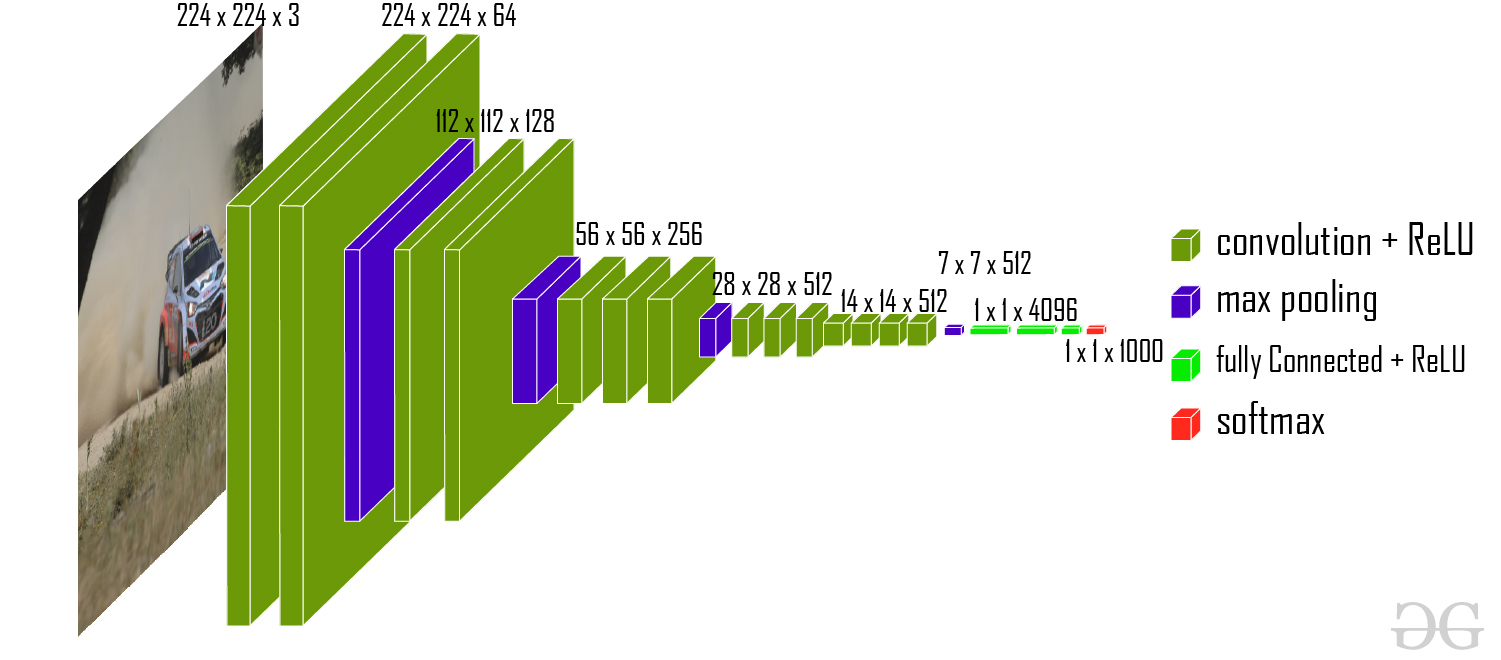



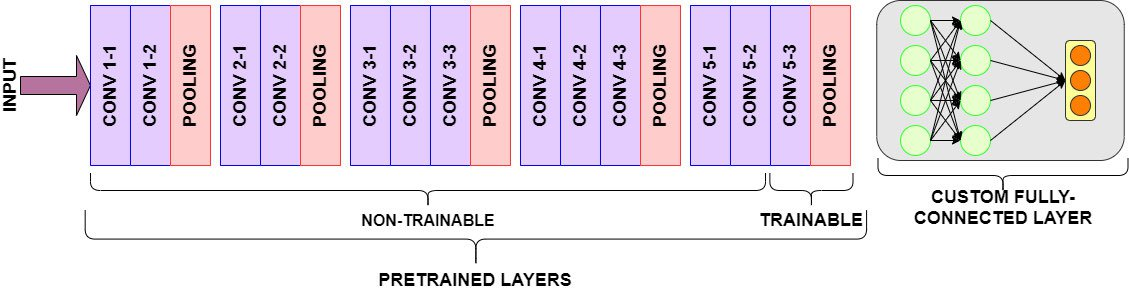



**VGG16 is a type of CNN (Convolutional Neural Network) that is considered to be one of the best computer vision models to date. The creators of this model evaluated the networks and increased the depth using an architecture with very small (3 × 3) convolution filters, which showed a significant improvement on the prior-art configurations.The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.**
reference: GeeksforGeeks

Implementation of model is done by Transfer technique VGG-16 to build the unet architecture from the pre-trained vgg model. The given method used sequential API which didn't gave considerable increase in iou values

In [19]:
# In this notebook model was implemented using the sequential API, it only gave val_iou_score around 0.21. Therefore, model is implemented by Transfer Learning Technique using VGG-16 from the pre-trained vgg model.

####Step1 : Create a base model
IMG_SHAPE = (480, 480, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

####Step 2: Freezing the base
# Freezing prevents the weights in a given layer from being updated during training
# VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

#The base model architecture summary
base_model.summary()

####Step 3: Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

#The final model architecture summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

# Building UNet model with segmentation_models

Segmentation models is python library with Neural Networks for Image Segmentation based on PyTorch.

The main features of this library are:

* High level API (just two lines to create neural network)
* 4 models architectures for binary and multi class segmentation (including legendary Unet)
* 30 available encoders for each architecture
* All encoders have pre-trained weights for faster and better convergence

In [20]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path

model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Load model and Compile

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from segmentation_models.metrics import iou_score
import datetime, os

""" Hyperparameters """

img_shape = (480, 480, 3) #input shapes changed to (480,480,3) from (256,256,3) ,as we have updated the value above.  
num_classes = 4
lr = 1e-5 #5 Decreased learning rate gives better generalization
batch_size = 16 #Increasing the batch size can provide better performance
epochs = 30 #25Increased epochs give better scores

""" Model building and compiling """

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8, decay=1e-6),
              metrics = metrics)

#Epsilon and Decay are added as a way to increase the performance.
#Epsilon is a very small number to prevent any division by zero in the implementation. 
#Decay helps us to increase performance by reducing the momentum of the optimizer. 
#Adam uses Momentum and Adaptive Learning Rates to converge faster.
               

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """
#Callbacks is a tool to customize the behavior of a Keras model during training, evaluation, or inference.
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True),
        # Callback to save the Keras model or model weights at some frequency.

        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), 
         # Reduce learning rate when a metric has stopped improving.
    
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'), 
        #Stop training when a monitored metric has stopped improving.


]

## Train model

In [30]:
# Fitting the model
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

Epoch 1/30
488/488 [==============================] - 797s 2s/step - loss: 0.8136 - iou_score: 0.0531 - f1-score: 0.0821 - val_loss: 0.6229 - val_iou_score: 0.1148 - val_f1-score: 0.1569

Epoch 00001: val_iou_score improved from -inf to 0.11481, saving model to models/LunarModel.h5
Epoch 2/30
488/488 [==============================] - 802s 2s/step - loss: 0.5029 - iou_score: 0.1670 - f1-score: 0.1988 - val_loss: 0.4309 - val_iou_score: 0.1997 - val_f1-score: 0.2220

Epoch 00002: val_iou_score improved from 0.11481 to 0.19974, saving model to models/LunarModel.h5
Epoch 3/30
488/488 [==============================] - 800s 2s/step - loss: 0.3562 - iou_score: 0.2212 - f1-score: 0.2346 - val_loss: 0.3001 - val_iou_score: 0.2331 - val_f1-score: 0.2413

Epoch 00003: val_iou_score improved from 0.19974 to 0.23315, saving model to models/LunarModel.h5
Epoch 4/30
488/488 [==============================] - 801s 2s/step - loss: 0.2644 - iou_score: 0.2761 - f1-score: 0.2830 - val_loss: 0.2351 - val

KeyboardInterrupt: 

In [ ]:
print(model_history.history)

## Improvement Summary Table
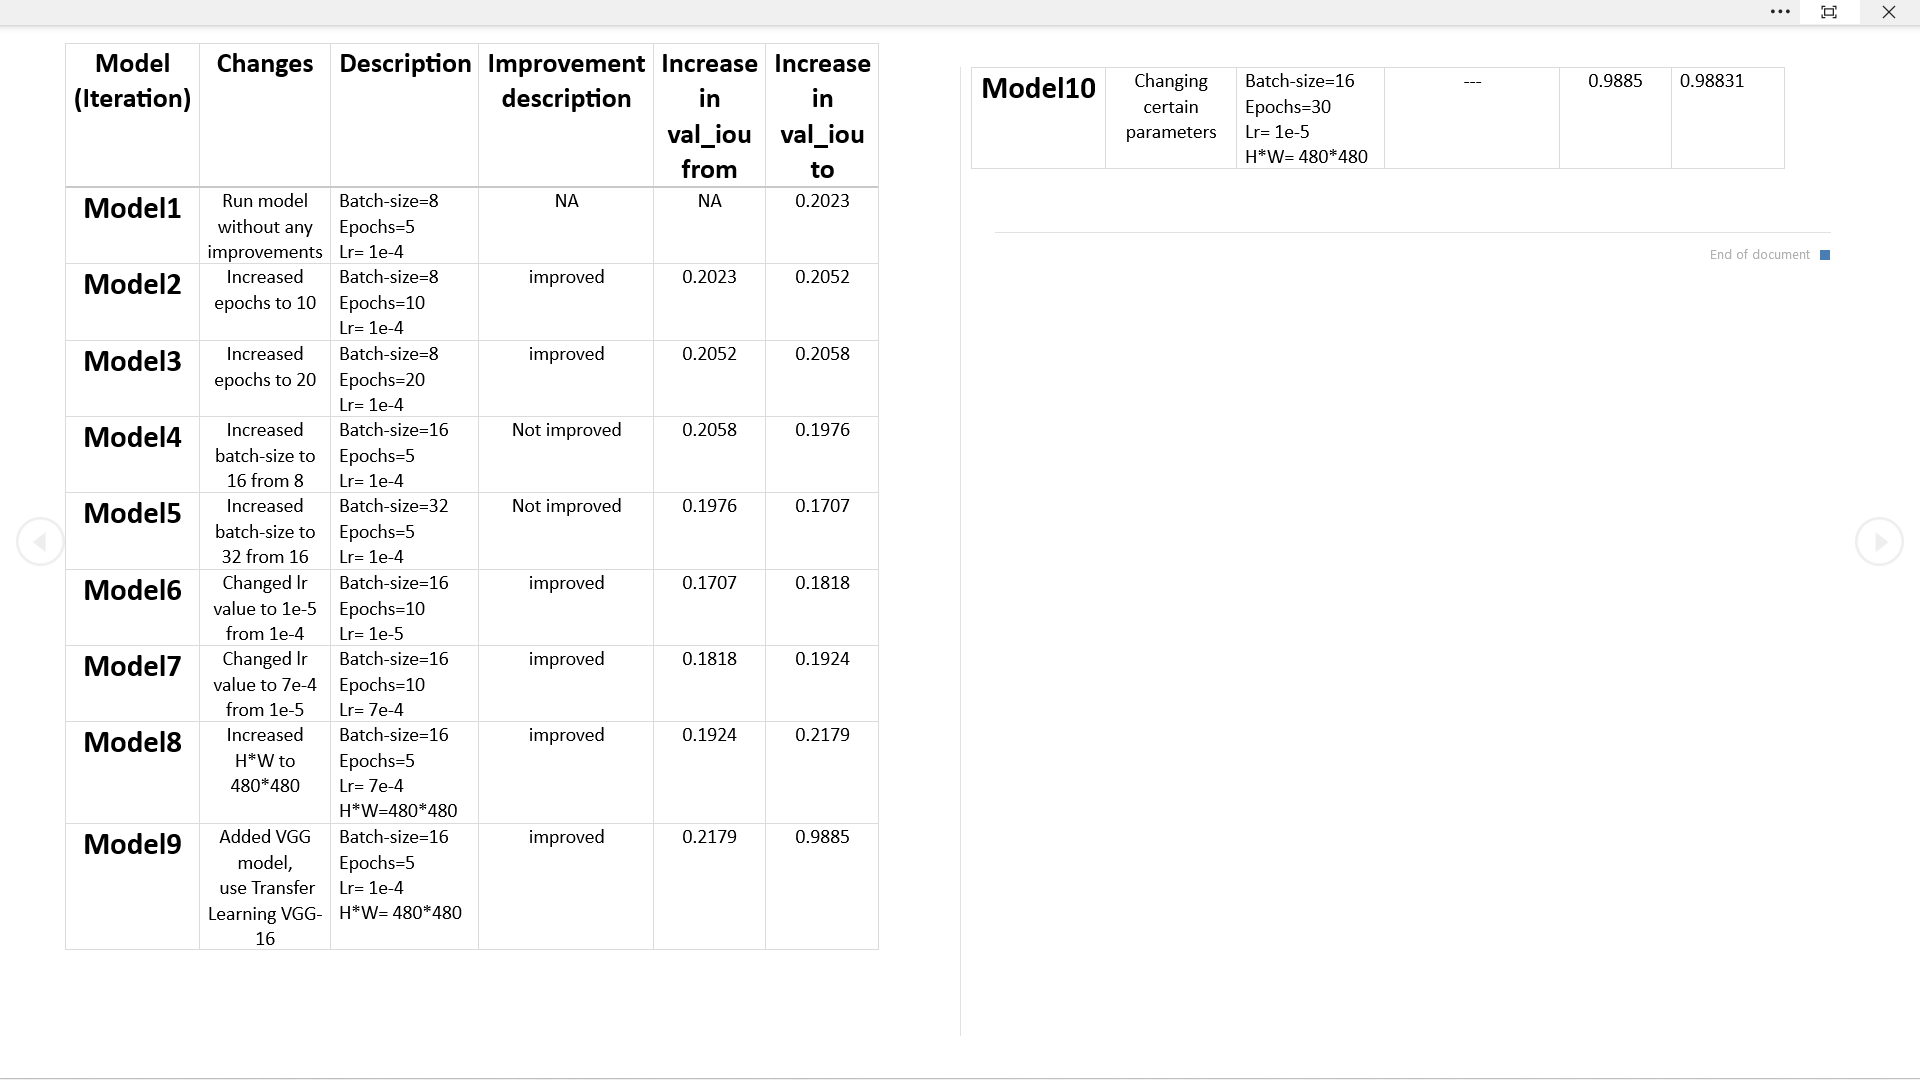

## Model Iteration History

In [25]:
#epoches=5
history_1={'loss': [0.5763017535209656, 0.312284916639328, 0.21098951995372772, 0.14931520819664001, 0.11178451031446457], 'iou_score': [0.12069616466760635, 0.160179004073143, 0.18133418262004852, 0.19289641082286835, 0.19886870682239532], 'val_loss': [0.3213437795639038, 0.28393125534057617, 0.21490450203418732, 0.1368836909532547, 0.09481748938560486], 'val_iou_score': [0.15639014542102814, 0.17137199640274048, 0.18971307575702667, 0.19483810663223267, 0.20228108763694763]}

#epoches=10
history_2={'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

#epoches=20
history_3 ={'loss': [0.5231246948242188, 0.29555752873420715, 0.1906273365020752, 0.1472758799791336, 0.11205197125673294, 0.10782746225595474, 0.08973213285207748, 0.0702207162976265, 0.05447293072938919, 0.045201513916254044, 0.03672035038471222, 0.03309774026274681, 0.028841398656368256, 0.026001188904047012, 0.023984219878911972, 0.02635415643453598, 0.026804916560649872, 0.02383970469236374, 0.020823553204536438, 0.01983710378408432, 0.018271274864673615, 0.017161225900053978, 0.01563640683889389, 0.01541261188685894, 0.0139857716858387], 'iou_score': [0.1243908479809761, 0.16222189366817474, 0.1833956390619278, 0.1921129673719406, 0.19765444099903107, 0.1907443106174469, 0.19514665007591248, 0.200332909822464, 0.2048458606004715, 0.207950621843338, 0.21014545857906342, 0.21085435152053833, 0.21234752237796783, 0.21192960441112518, 0.21221977472305298, 0.20339864492416382, 0.20455610752105713, 0.20718446373939514, 0.20775827765464783, 0.20810995995998383, 0.20792241394519806, 0.20899656414985657, 0.20883379876613617, 0.20895922183990479, 0.20606213808059692], 'val_loss': [0.3504341244697571, 0.2270856350660324, 0.15799111127853394, 0.12615768611431122, 0.1073581874370575, 0.09883617609739304, 0.07801088690757751, 0.05247480422258377, 0.045154619961977005, 0.03397982940077782, 0.038976382464170456, 0.025591908022761345, 0.023734865710139275, 0.030592909082770348, 0.022325491532683372, 0.025612615048885345, 0.026377787813544273, 0.020990507677197456, 0.03191310167312622, 0.015842529013752937, 0.015667308121919632, 0.026735998690128326, 0.014911118894815445, 0.014886182732880116, 0.01278657466173172], 'val_iou_score': [0.1469690501689911, 0.17493127286434174, 0.19046643376350403, 0.19754275679588318, 0.196194589138031, 0.1899973303079605, 0.1984904706478119, 0.20007845759391785, 0.20677940547466278, 0.20857937633991241, 0.20819391310214996, 0.2120230495929718, 0.21219679713249207, 0.21205317974090576, 0.21221648156642914, 0.19799432158470154, 0.20467513799667358, 0.20470266044139862, 0.2034219652414322, 0.20694592595100403, 0.20698517560958862, 0.20529471337795258, 0.20798468589782715, 0.20643728971481323, 0.20589295029640198]}

#Increasing batchsize to 16
history_4={'loss': [0.3596359193325043, 0.1807146519422531, 0.13113781809806824, 0.11097624152898788, 0.0947754830121994], 'iou_score': [0.15074843168258667, 0.18402239680290222, 0.18978948891162872, 0.19106322526931763, 0.19589830935001373], 'val_loss': [0.23183178901672363, 0.12856310606002808, 0.11421748995780945, 0.0972159281373024, 0.0834023579955101], 'val_iou_score': [0.1727718859910965, 0.1939355880022049, 0.18968139588832855, 0.19391703605651855, 0.1975906938314438]}

#Increasing batchsize to 32
history_5={'loss': [0.7248206734657288, 0.5161601305007935, 0.42403894662857056, 0.35522088408470154, 0.29298070073127747], 'iou_score': [0.10012875497341156, 0.12443922460079193, 0.14006954431533813, 0.1533246785402298, 0.16520839929580688], 'val_loss': [0.5131872296333313, 0.42748281359672546, 0.38201579451560974, 0.3414659798145294, 0.2476150542497635], 'val_iou_score': [0.11519315093755722, 0.13408103585243225, 0.14653630554676056, 0.15406011044979095, 0.17065289616584778]}

#Decreasing learning rate by 1e-5
history_6= {'loss': [0.7185201048851013, 0.4435991048812866, 0.36302536725997925, 0.31867000460624695, 0.2888352572917938, 0.26406604051589966, 0.24332734942436218, 0.2250581681728363, 0.21031779050827026, 0.19598449766635895], 'iou_score': [0.10598844289779663, 0.13957399129867554, 0.15062516927719116, 0.1571570336818695, 0.16232825815677643, 0.16662733256816864, 0.17044875025749207, 0.1739654541015625, 0.17719340324401855, 0.18016085028648376], 'val_loss': [0.45045924186706543, 0.4064871370792389, 0.36277005076408386, 0.30910593271255493, 0.2760678231716156, 0.2552853524684906, 0.2386995106935501, 0.2193075567483902, 0.20787449181079865, 0.194619819521904], 'val_iou_score': [0.1314612776041031, 0.14486877620220184, 0.1524887979030609, 0.15964347124099731, 0.16479076445102692, 0.1682218611240387, 0.17220351099967957, 0.17542117834091187, 0.17860019207000732, 0.18176595866680145]}
#Decreasing learning rate by 7e-4
history_7= {'loss': [0.13248153030872345, 0.03814716264605522, 0.03301949426531792, 0.02256428264081478, 0.021913638338446617, 0.01712057739496231, 0.019262690097093582, 0.024305909872055054, 0.014121697284281254, 0.011709860526025295], 'iou_score': [0.1899181604385376, 0.20991572737693787, 0.20558331906795502, 0.20909589529037476, 0.20610886812210083, 0.20736359059810638, 0.20350413024425507, 0.20084141194820404, 0.20455868542194366, 0.20508283376693726], 'val_loss': [0.06893859058618546, 0.05925099924206734, 0.017419321462512016, 0.19829583168029785, 0.06343021988868713, 0.014118439517915249, 0.01477801613509655, 0.010991891846060753, 0.05619960278272629, 0.01609151065349579], 'val_iou_score': [0.20373648405075073, 0.18704825639724731, 0.20036651194095612, 0.17452870309352875, 0.18523932993412018, 0.1985536515712738, 0.1882067322731018, 0.19105558097362518, 0.18843963742256165, 0.19238989055156708]}

#Increasing height and width
history_8= {'loss': [0.24489934742450714, 0.05959697812795639, 0.03594345971941948, 0.03655381128191948, 0.024292953312397003], 'iou_score': [0.17197279632091522, 0.21078842878341675, 0.21701273322105408, 0.2115839421749115, 0.21542750298976898], 'val_loss': [0.06276427209377289, 0.1867499053478241, 0.19909168779850006, 0.02630932629108429, 0.01903170719742775], 'val_iou_score': [0.18434923887252808, 0.19411800801753998, 0.18638163805007935, 0.2069907784461975, 0.2179463505744934]}

#adding VGG
history_9= {'loss': [0.21714180707931519, 0.05253290757536888, 0.03640696778893471, 0.03496156632900238, 0.02911597117781639], 'iou_score': [0.42949366569519043, 0.973760187625885, 0.9793726205825806, 0.9652519822120667, 0.964123547077179], 'f1-score': [0.4410228729248047, 0.9809364676475525, 0.9886745810508728, 0.9797305464744568, 0.9795390963554382], 'val_loss': [0.11080129444599152, 0.063847616314888, 0.046125948429107666, 0.0440225712954998, 0.02898530289530754], 'val_iou_score': [0.5723525881767273, 0.9884955883026123, 0.9750454425811768, 0.9827542901039124, 0.9435029029846191], 'val_f1-score': [0.5789872407913208, 0.9940927028656006, 0.9868389368057251, 0.9910354018211365, 0.9680457711219788], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

#Model10
history_10=

## Analysing the output

In [26]:
#create Plotgraph function to plot a graph
import matplotlib.pyplot as plt
def Plotgraph(history1, history2):
        plt.plot(history1['val_iou_score'])
        plt.plot(history2['val_iou_score'])
        plt.title('Model Performance')
        plt.xlabel('epochs')
        plt.ylabel('val_iou_score')
        plt.legend(['1st observation', '2st observation'])
        plt.show()

> ### 1. Plotting for impact of epoch increment on u-net's val_iou_score¶

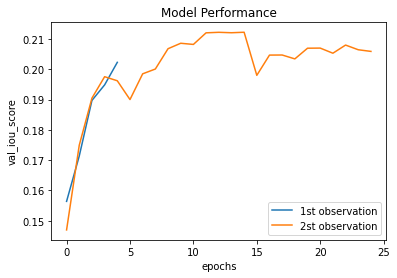



The graph shows two training runs 1st(history_1) with 5 epochs and 2nd(history_3) with 20 epochs. It can be observed that there is slight increase in val_iou_score but no benefit is seen in performance


In [27]:
#Observe change in val_iou_score by increasing epochs
Plotgraph(history_1,history_3)
print()
print("\nThe graph shows two training runs 1st(history_1) with 5 epochs and 2nd(history_3) with 20 epochs. It can be observed that there is slight increase in val_iou_score but no benefit is seen in performance")

> ### 2. Plotting for impact of decrement in learning rate to build unet on val_iou_score

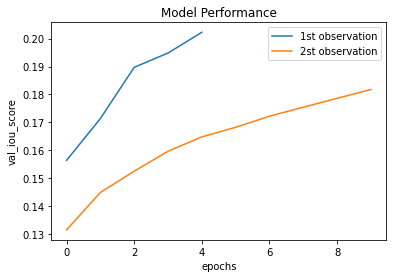



As it is observed from the plot there is a strong increase when learning rate is decreased and also a slight increase in val_iou_score


In [28]:
#Observe change in val_iou_score by decreasing learning rate
Plotgraph(history_1,history_6)
print()
print("\nAs it is observed from the plot there is a strong increase when learning rate is decreased and also a slight increase in val_iou_score")


> ## 3. Plotting for impact of using transfer learning technique to build unet on val_iou_score

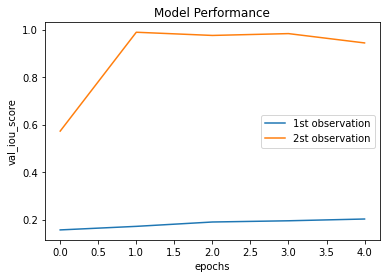



There is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.


In [29]:
#Observe change in val_iou_score by impacting transfer learning
Plotgraph(history_1,history_9)
print()
print("\nThere is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.")

---
# <center> THE END